In [39]:
from textblob import TextBlob
import csv
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
with open('csvdata.csv', 'r', encoding="utf8") as f: #Read from a csv file, parsed with all fb messages from all conversations
  reader = csv.reader(f)
  datalist = tuple(reader)

In [42]:
#Separate a single conversation between myself and sample user
sophchat = [msg for msg in datalist if ("USER-S@facebook.com" in msg[0] and "USER-Y@facebook.com" in msg[0])]

In [119]:
chat = [TextBlob(msg[3]) for msg in sophchat]
dates = [msg[2][:10] for msg in sophchat]
times = [msg[2][11:16] for msg in sophchat]
sender = ['S' if msg[1][:1] == 'S' or msg[1] == 'USER-S@facebook.com' else 'Y' for msg in sophchat]
#Facebook used to store the sender information as the name, now it is the user ID's. We want to capture both
print(dates[5], times[5], sender [5])

2015-04-30 03:48 S


In [120]:
chatdf = [] #Extract sentiments, parse dates, and times from facebook data
for i in range(len(chat)):
    phrase = chat[i]
    chatdf.extend([{'subjectivity' : phrase.sentiment.subjectivity
                    , 'polarity' : phrase.sentiment.polarity
                    , 'date' : dates[i], 'time' : times[i]
                    ,'sender' : sender[i]
                   ,'msg' : phrase}])

In [121]:
schatdf = [msg for msg in chatdf if (msg['sender'] == 'S')] #this is the dataset containing all the messages sent by 'S'
ychatdf = [msg for msg in chatdf if (msg['sender'] == 'Y')] #this is the dataset containing all the messages sent by 'Y'
minPols = [msg for msg in chatdf if (msg['polarity'] == -1.0)]
maxPols = [msg for msg in chatdf if (msg['polarity'] == 1.0)]
schatdf[0]['sender']

'S'

In [122]:
chatdf = pd.DataFrame(chatdf) #Converting all datasets to dataframe
schatdf = pd.DataFrame(schatdf)
ychatdf = pd.DataFrame(ychatdf)
del chatdf['msg'] #The message text is no longer needed
del schatdf['msg']
del ychatdf['msg']
print(chatdf.head(3))
chatdf.describe()

         date  polarity sender  subjectivity   time
0  2015-04-29      0.00      Y          0.00  18:06
1  2015-04-29      0.60      Y          1.00  18:06
2  2015-04-29      0.25      S          0.25  23:04


,polarity,subjectivity
count,16954.000000,16954.000000
mean,0.182520,0.424653
std,0.317105,0.317170
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.146771,0.483333
75%,0.366667,0.666667
max,1.000000,1.000000


In [123]:
#Function to iterate over all messages in the same day and average the values. 
#Perhaps there's a simpler way to do this I haven't found
def groupByDay(chat_df):
    n = -1
    chatdfGroupedByDay = []
    tempDate = chat_df['date'][0]
    print(tempDate)
    for i in range(len(chat_df.index)):
        if tempDate == chat_df['date'][i]:
            n+= 1
        else:
            sentimentMean = round(chat_df['subjectivity'][i-n:i-1].mean(), 3)
            polarityMean = round(chat_df['polarity'][i-n:i-1].mean(), 3)
            chatdfGroupedByDay.extend([{'subjectivity' : 0 if np.isnan(sentimentMean) else sentimentMean*5000
                                    , 'polarity' : 0 if np.isnan(polarityMean) else polarityMean*5000
                                    , 'date' : tempDate, 'entries' : n}])
            tempDate = chat_df['date'][i]
            n=1
    return chatdfGroupedByDay

In [124]:
chatdfGroupedByDay = pd.DataFrame(groupByDay(chatdf))#Group the chats by day
schatdfGroupedByDay = pd.DataFrame(groupByDay(schatdf))
ychatdfGroupedByDay = pd.DataFrame(groupByDay(ychatdf))
chatdfGroupedByDay.index = pd.to_datetime(chatdfGroupedByDay['date']) #Convert to convenient indexable pandas datetime format
schatdfGroupedByDay.index = pd.to_datetime(schatdfGroupedByDay['date']) #for time series analysis
ychatdfGroupedByDay.index = pd.to_datetime(ychatdfGroupedByDay['date'])
del chatdfGroupedByDay['date'] #We don't need the date column anymore since it's the index now
del schatdfGroupedByDay['date']
del ychatdfGroupedByDay['date']
chatdfGroupedByDay.head(3) #Display sample timeseries index

2015-04-29
2015-04-29
2015-04-29


,entries,polarity,subjectivity
date,,,
2015-04-29,2,3000.0,5000.0
2015-04-30,117,325.0,1700.0
2015-05-01,8,215.0,500.0


In [125]:
del chatdfGroupedByDay['subjectivity'] #I am not interested in the subjectivity parameter
del schatdfGroupedByDay['subjectivity']
del ychatdfGroupedByDay['subjectivity']
chatdfGroupedByMonth = chatdfGroupedByDay.resample('MS').agg({'polarity': np.mean, 'entries': np.sum}) #resample into months
schatdfGroupedByMonth = schatdfGroupedByDay.resample('MS').agg({'polarity': np.mean, 'entries': np.sum})
ychatdfGroupedByMonth = ychatdfGroupedByDay.resample('MS').agg({'polarity': np.mean, 'entries': np.sum})
chatdfGroupedByMonth.head(5) #Example

,entries,polarity
date,,
2015-04-01,119.0,1662.500000
2015-05-01,461.0,741.176471
2015-06-01,856.0,1094.687500
2015-07-01,1818.0,946.153846
2015-08-01,68.0,1045.000000


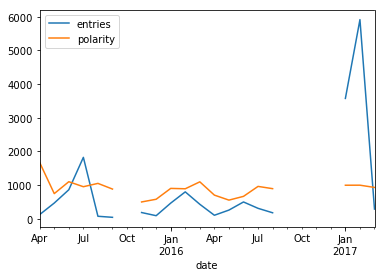

In [134]:
chatdfGroupedByMonth.plot() #Entries is the total number of messages exchanged, polarity is scaled [-5000,5000]

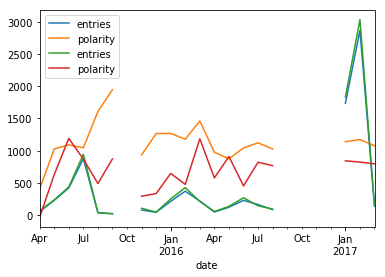

In [127]:
ax = ychatdfGroupedByMonth.plot() #Orange/Blue = Y; Red/Green = S
schatdfGroupedByMonth.plot(ax=ax)

In [133]:
#This displays the most polarized messages in our exchange
print("~~~~~~Y's messages with lowest polarity~~~~~~~~~~~~~")
[print(i['msg']) for i in minPols[:15] if i['sender'] == 'Y'] #The index values here are hardcoded because I don't know the order
print("~~~~~~Y's messages with highest polarity~~~~~~~~~~~~~")#in which our entries occur in the list; they are not sorted by sender
[print(i['msg']) for i in maxPols[:8] if i['sender'] == 'Y']
print("~~~~~~S' messages with lowest polarity~~~~~~~~~~~~~")
[print(i['msg']) for i in minPols[:9] if i['sender'] == 'S']
print("~~~~~~S' messages with highest polarity~~~~~~~~~~~~~")
[print(i['msg']) for i in maxPols[:21] if i['sender'] == 'S']

~~~~~~Y's messages with lowest polarity~~~~~~~~~~~~~
Yeah she's batshit insane
every photo you send of him is really awful and I delete it from my gallery immediately
I do I do. But I'm not that evil, dw
LOOL man you're gonna squeeze everything out of him! You're like a terrible drug xD
Loool I'm laughing an awful lot
~~~~~~Y's messages with highest polarity~~~~~~~~~~~~~
What lol that's the easiest part for me!
Mm well that'l be over soon too :D
Awesome xD
LOL yess do it! Juicy gossip
Yes, isn't it wonderful? xD
~~~~~~S' messages with lowest polarity~~~~~~~~~~~~~
Horrible woman
Uhm because I always tell him that his hair is awful
Uhm it's just an awful hairstyle didn't you see
That sounds horrible
That sounds awful xD
~~~~~~S' messages with highest polarity~~~~~~~~~~~~~
Lool that Sounds Awesome
Naah but my dad is on fb he would be happy!
Perfect
Tried to look awesome and stuff because he should be regretting
Lool that song fits perfectly


[None, None, None, None, None]